
**Amyloid Classification Experiment**

In this experiment, we developed an XGBoost classifier to predict amyloid risk levels using non-invasive features, including clinical scores, MRI-derived volumetric data, and APOE4 genotype. We applied minimal feature engineering, incorporating biologically meaningful interactions (e.g., APOE4_Hippocampus, 'APOE4_AGE') and used SHAP values for feature importance analysis and selection. The final model achieved an AUC-ROC of 0.815, indicating strong discriminative performance. These results suggest that the model can support preliminary cohort screening and serve as an auxiliary tool in early clinical decision-making for Alzheimer's disease.

In [ ]:
#Import some libraries
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("df_clean (2).csv")

In [ ]:
df = df.drop(columns=['PTAU_bl', 'TAU_bl'])

In [ ]:
#In the ABETA_bl some values are simply > 1700 upper limit, we converted these to 1700

df["ABETA_bl"] = df["ABETA_bl"].astype(str).str.replace('>', '', regex=False).str.replace('<', '', regex=False).astype(float)
df["ABETA_bl"] = df["ABETA_bl"].replace(">1700", "1700").astype(float)


In [ ]:
#Dropping NA

df = df.dropna()
df.shape

(1215, 29)

In [ ]:
# categorization for Elecsys-transformed values
# Converting the Amyloid levels to High and low risk
def categorize_abeta_elecsys(value):
    if pd.isna(value):
        return 'Missing'
    elif value < 880:
        return 'High Risk (<880)'
    elif 880 <= value <= 1200:
        return 'Intermediate Risk (880-1200)'
    else:  # >1200
        return 'Low Risk (>1200)'

# Apply to your dataset
df['ABETA_Risk'] = df['ABETA_bl'].apply(categorize_abeta_elecsys)

# Verify new distribution
risk_counts = df['ABETA_Risk'].value_counts()
print("Corrected ABETA Risk Category Counts:")
print(risk_counts)

Corrected ABETA Risk Category Counts:
ABETA_Risk
High Risk (<880)                633
Low Risk (>1200)                397
Intermediate Risk (880-1200)    185
Name: count, dtype: int64


In [ ]:
# binary target
df['Amyloid_Positive'] = df['ABETA_Risk'].apply(
    lambda x: 1 if x == 'High Risk (<880)' else 0
)

# Check distribution
print(f"Amyloid Positive: {df['Amyloid_Positive'].sum()} samples")
print(f"Amyloid Negative: {len(df) - df['Amyloid_Positive'].sum()} samples")

Amyloid Positive: 633 samples
Amyloid Negative: 582 samples


In [ ]:
# Identify intermediate risk cases
intermediate_mask = df['ABETA_Risk'] == 'Intermediate Risk (880-1200)'

# Create separate dataset for borderline cases
borderline_df = df[intermediate_mask].copy()

**Feature enginnering and data standardization**

In [ ]:
# Gender encoding
df['PTGENDER'] = df['PTGENDER'].map({'Male': 0, 'Female': 1})


In [ ]:
df.shape

(1215, 31)

In [ ]:
df.columns

Index(['RID', 'PTID', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4',
       'ABETA_bl', 'FDG_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'ADASQ4_bl',
       'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl',
       'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'LDELTOTAL_BL',
       'TRABSCOR_bl', 'FAQ_bl', 'MOCA_bl', 'Ventricles_bl', 'Hippocampus_bl',
       'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl',
       'ABETA_Risk', 'Amyloid_Positive'],
      dtype='object')

In [ ]:
df = df.drop(columns=['RID', 'PTID', 'DX_bl','ABETA_bl','ABETA_Risk',])

In [ ]:
df.columns

Index(['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'FDG_bl', 'CDRSB_bl',
       'ADAS11_bl', 'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'RAVLT_immediate_bl',
       'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl',
       'LDELTOTAL_BL', 'TRABSCOR_bl', 'FAQ_bl', 'MOCA_bl', 'Ventricles_bl',
       'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl',
       'MidTemp_bl', 'ICV_bl', 'Amyloid_Positive'],
      dtype='object')

In [ ]:
df['Hippocampus_norm'] = df['Hippocampus_bl'] / df['ICV_bl']
df['MidTemp_norm'] = df['MidTemp_bl'] / df['ICV_bl']
df['Entorhinal_norm'] = df['Entorhinal_bl'] / df['ICV_bl']


In [ ]:
# Add APOE4 interaction terms
df['APOE4_AGE'] = df['APOE4'] * df['AGE']
df['APOE4_Hippocampus'] = df['APOE4'] * df['Hippocampus_norm']

In [ ]:

# FDG-PET × Age interaction
df['FDG_Age'] = df['FDG_bl'] * df['AGE']

In [ ]:
# Cognitive composite score
df['Cog_Composite'] = (df['ADAS13_bl'] + df['MMSE_bl'] + df['RAVLT_learning_bl']) / 3

# FDG-PET × APOE4 interaction
df['FDG_APOE4'] = df['FDG_bl'] * df['APOE4']

# Normalized ventricular volume
df['Ventricles_norm'] = df['Ventricles_bl'] / df['ICV_bl']

In [ ]:
# Simply use ADAS13_bl and drop ADAS11_bl entirely
df = df.drop(columns=['ADAS11_bl'])

In [ ]:
df.columns

Index(['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'FDG_bl', 'CDRSB_bl',
       'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'RAVLT_immediate_bl',
       'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl',
       'LDELTOTAL_BL', 'TRABSCOR_bl', 'FAQ_bl', 'MOCA_bl', 'Ventricles_bl',
       'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl',
       'MidTemp_bl', 'ICV_bl', 'Amyloid_Positive', 'Hippocampus_norm',
       'MidTemp_norm', 'Entorhinal_norm', 'APOE4_AGE', 'APOE4_Hippocampus',
       'FDG_Age', 'Cog_Composite', 'FDG_APOE4', 'Ventricles_norm'],
      dtype='object')

In [ ]:
final_features = [
    'AGE',
    'APOE4',
    'FDG_bl',
    'CDRSB_bl',         # Clinical dementia rating
    'ADAS13_bl',        # Comprehensive cognitive score
    'MMSE_bl',          # Global cognitive screen
    'RAVLT_immediate_bl',  # Verbal memory encoding
    'RAVLT_learning_bl',   # Learning rate
    'LDELTOTAL_BL',     # Delayed recall (sensitive to early amyloid)
    'TRABSCOR_bl',      # Executive function
    'FAQ_bl',           # Functional activities
    'Ventricles_bl',    # Enlargement correlates with amyloid burden
    'Hippocampus_norm', # ICV-normalized (medial temporal atrophy)
    'MidTemp_norm',     # ICV-normalized (lateral temporal atrophy)
    'Entorhinal_norm',
    "APOE4_Hippocampus",
    'APOE4_AGE','Cog_Composite','FDG_APOE4','Ventricles_norm'

]

In [ ]:
# Define features to drop
drop_features = [
    'PTGENDER', 'PTEDUCAT', 'ADASQ4_bl',
    'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl',
    'MOCA_bl', 'WholeBrain_bl', 'Fusiform_bl',
    'ICV_bl', 'Hippocampus_bl', 'MidTemp_bl', 'Entorhinal_bl'
]

# Create final dataset
df_final = df.drop(columns=drop_features)

# Verify final features (should be 15 + target)
print(df_final.columns)

Index(['AGE', 'APOE4', 'FDG_bl', 'CDRSB_bl', 'ADAS13_bl', 'MMSE_bl',
       'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'LDELTOTAL_BL',
       'TRABSCOR_bl', 'FAQ_bl', 'Ventricles_bl', 'Amyloid_Positive',
       'Hippocampus_norm', 'MidTemp_norm', 'Entorhinal_norm', 'APOE4_AGE',
       'APOE4_Hippocampus', 'FDG_Age', 'Cog_Composite', 'FDG_APOE4',
       'Ventricles_norm'],
      dtype='object')


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV


final_features = ['AGE', 'APOE4', 'CDRSB_bl', 'ADAS13_bl', 'MMSE_bl',
    'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'LDELTOTAL_BL',
    'TRABSCOR_bl', 'FAQ_bl', 'Ventricles_bl',
    'Hippocampus_norm', 'MidTemp_norm', 'Entorhinal_norm',
    "APOE4_Hippocampus", 'APOE4_AGE','Cog_Composite','Ventricles_norm']


X = df[final_features]
y = df['Amyloid_Positive']

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
df.shape

(1215, 34)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters Found:
{'xgb__subsample': 0.6, 'xgb__n_estimators': 100, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.01, 'xgb__colsample_bytree': 0.6}

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       116
           1       0.72      0.80      0.76       127

    accuracy                           0.73       243
   macro avg       0.74      0.73      0.73       243
weighted avg       0.73      0.73      0.73       243


Confusion Matrix:
[[ 76  40]
 [ 25 102]]

AUC-ROC: 0.815


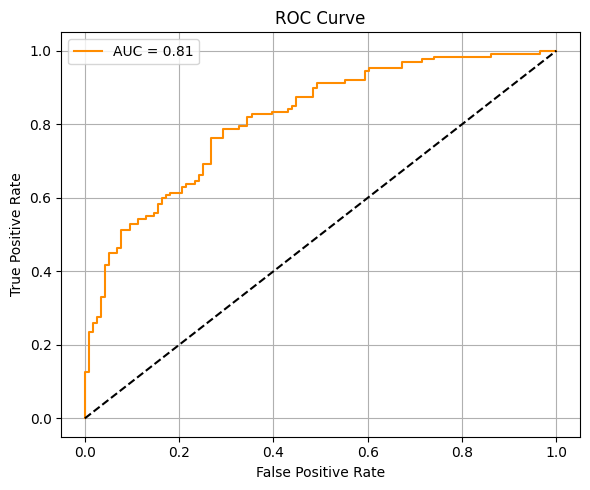

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

scale_pos_weight = 633 / 582

# Define pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=scale_pos_weight
    ))
])

# Define parameter grid for tuning
param_dist = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 4, 5, 6],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized search
search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit model
search.fit(X_train, y_train)

# Best model
best_model = search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Best Parameters Found:")
print(search.best_params_)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nAUC-ROC: {roc_auc:.3f}")

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
%pip install scikit-optimize

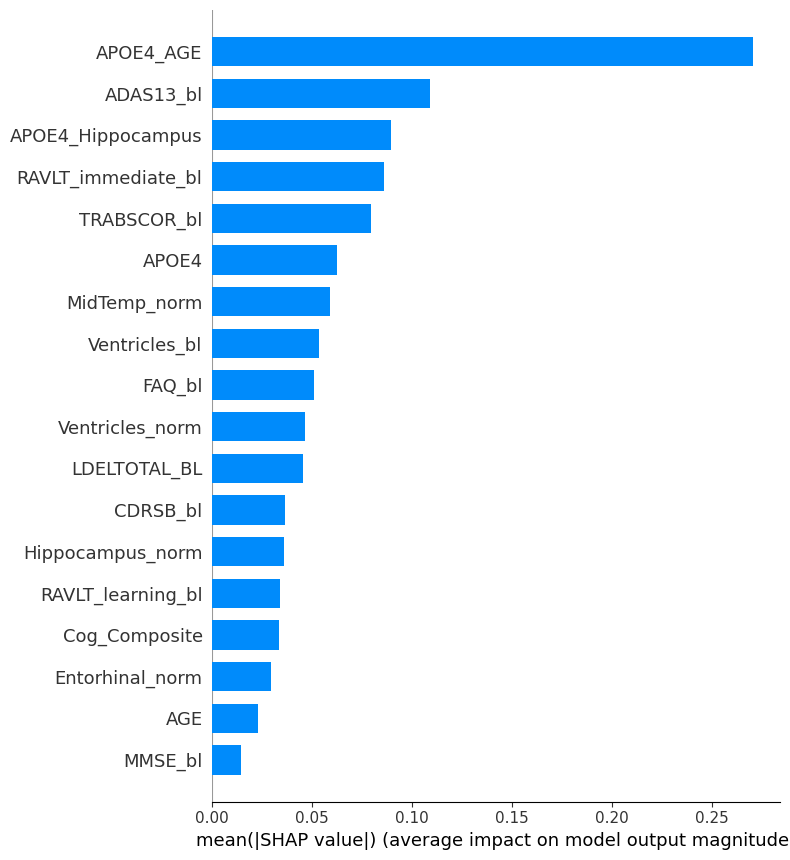

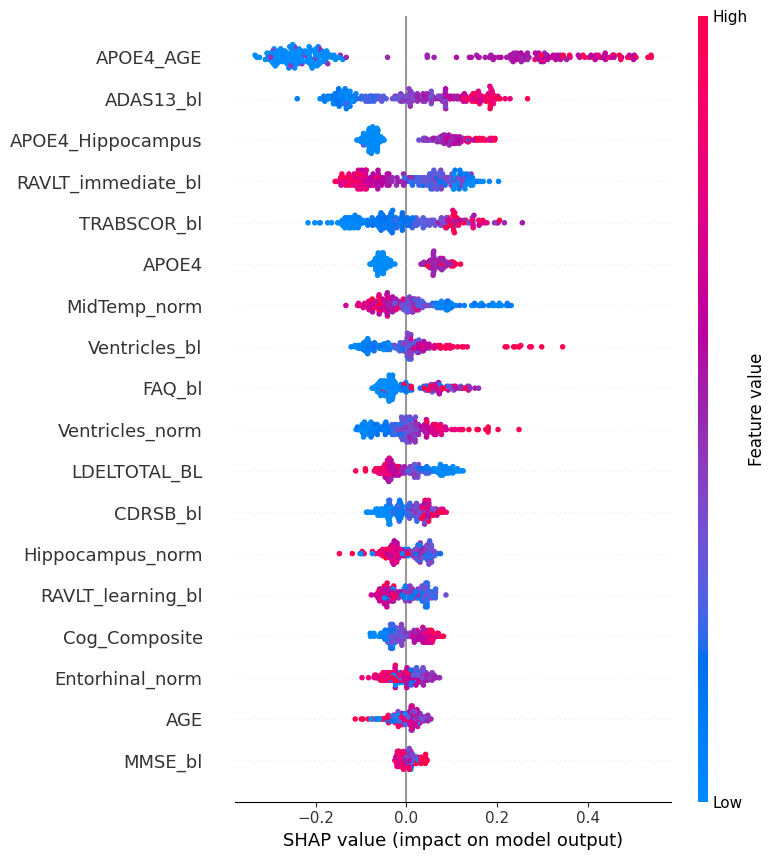

In [ ]:
import shap
import pandas as pd

# Extract trained XGBClassifier and scaler from the pipeline
scaler = best_model.named_steps['scaler']
xgb_model = best_model.named_steps['xgb']

# Scale the training and test sets (as done in the pipeline)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Rebuild DataFrames for SHAP with correct feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Initialize SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_scaled_df)

# Compute SHAP values for test set
shap_values = explainer(X_test_scaled_df)

# --- SHAP Summary Plot (Feature Importance) ---
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar")

# --- SHAP Beeswarm Plot (Detailed per sample impact) ---
shap.summary_plot(shap_values, X_test_scaled_df)


**Amyloid Classification Experiment**

The main idea of this experiment was to develop an XGBoost classifier to predict amyloid risk levels using non-invasive features (clinical scores, MRI volumetric data, and APOE4 genotype). The goal is to explore the potential of such a model to aid in clinical trial triage and serve as an auxiliary tool in early clinical decision-making for Alzheimer's disease.


We applied appropriate Feature engineering and interactions we also optimized the hyperparameters with hyperparameter tunning.

**Results**

The best model achieved an AUC-ROC of 0.815 on the test set.
Evaluation metrics including Classification Report and Confusion Matrix were also generated.


**Feature Importance Analysis (SHAP):**

SHAP values were computed to identify the contributory features influencing the model's predictions. This analysis helps in understanding which features are most important for classifying amyloid positivity.

**Potential Utility:**

Although this model has not reached clinical utility maturity, it shows promise. The approach of using non-invasive features and an XGBoost classifier demonstrates potential for preliminary cohort screening. Furthermore, the methodology employed here could potentially be extended to classify TAU and pTAU positivity using the same set of non-invasive features, which would be a valuable step in understanding the progression of Alzheimer's disease. The SHAP analysis provides crucial insights into the features driving these classifications.